In [47]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2.0


## Load GeneMANIA Raw Data
#### Source: http://genemania.org/data/archive/2021-04-19/Homo_sapiens.COMBINED/COMBINED.DEFAULT_NETWORKS.BP_COMBINING.txt 
Downloaded: November, 2021  
Last Updated: October 15, 2014	

In [3]:
GeneMANIA_Raw_v2 = pd.read_csv(wd+'/Network_Data_Raw/GeneMania_2021_COMBINED.DEFAULT_NETWORKS.BP_COMBINING.txt',sep='\t')

In [12]:
GeneMANIA_Raw_v2.head()

,Gene_A,Gene_B,Weight
0,O60762,P48506,2.700000e-05
1,Q8IZE3,P48506,6.800000e-08
2,Q9NSG2,P48506,1.100000e-07
3,P09769,P48506,1.000000e-07
4,Q9NSG2,P23511,9.100000e-05


In [4]:
GeneMANIA_Raw_Genes_v2 = list(set(GeneMANIA_Raw_v2['Gene_A']).union(set(GeneMANIA_Raw_v2['Gene_B'])))

In [5]:
# Get Edgelist of network
query_edgelist_v2 = GeneMANIA_Raw_v2[['Gene_A','Gene_B', 'Weight']].values.tolist()
print(len(query_edgelist_v2), "Total GeneMANIA Edges")

11749785 Total GeneMANIA Edges


## Convert Genes (from ensembl gene to gene symbol)

In [6]:
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(GeneMANIA_Raw_Genes_v2)

19680 Valid Query Genes
0 Invalid Query Genes


In [13]:
# Set scopes (gene naming systems to search)
scopes = "uniprot"

# Set fields (systems from which to return gene names from)
fields = "symbol,entrezgene"

In [14]:
# Query MyGene.Info
match_list_v2 = gct.query_batch(query_string_v2, scopes=scopes, fields=fields)

19863 Matched query results
Batch query complete: 13.73 seconds


In [17]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(match_list_v2, valid_genes_v2)

Queries without full matching results found: 1115

144 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 9.62 seconds


## Construct Converted Network

In [18]:
GeneMANIA_edgelist_symbol_v2 = gct.convert_edgelist(query_edgelist_v2, query_to_symbol_v2, weighted=True)

In [19]:
# Filter converted edge list
GeneMANIA_edgelist_symbol_filt_v2 = gct.filter_converted_edgelist(GeneMANIA_edgelist_symbol_v2, weighted=True)

11749785 input edges
60 self-edges removed
281566 edges with un-mapped genes removed
2481 duplicate edges removed
Edge list filtered: 7.69 seconds
11465678 Edges remaining


In [20]:
# Write network to file
gct.write_edgelist(GeneMANIA_edgelist_symbol_filt_v2, wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA_Symbol_2021.sif', binary=False)

Edge list saved: 15.72 seconds


In [21]:
# Create filtered network
GeneMANIA90_edgelist_v2 = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA_Symbol_2021.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                       q=0.9, delimiter='\t', verbose=True, save_path=wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA90_Symbol_2021.sif')

90.0% score: 9.5e-05
1140879 / 11465678 edges retained


# Version 1.0 (original)

## Load GeneMANIA Raw Data
#### Source: http://genemania.org/data/current/Homo_sapiens.COMBINED/COMBINED.DEFAULT_NETWORKS.BP_COMBINING.txt
Downloaded: July 28, 2016  
Last Updated: October 15, 2014	

2021 Note: There are minor differences in processing when re-running on the original dataset due to changes in ensembl database

In [27]:
GeneMANIA_Raw = pd.read_csv(wd+'/Network_Data_Raw/GeneMANIA_2014_10_15.txt',sep='\t')

In [28]:
GeneMANIA_Raw_Genes = list(set(GeneMANIA_Raw['Gene_A']).union(set(GeneMANIA_Raw['Gene_B'])))

In [29]:
# Get Edgelist of network
query_edgelist = GeneMANIA_Raw[['Gene_A','Gene_B', 'Weight']].values.tolist()
print(len(query_edgelist), "Total GeneMANIA Edges")

7290094 Total GeneMANIA Edges


## Convert Genes (from ensembl gene to gene symbol)

In [30]:
query_string, valid_genes, invalid_genes = gct.query_constructor(GeneMANIA_Raw_Genes)


19264 Valid Query Genes
0 Invalid Query Genes


In [31]:
# Set scopes (gene naming systems to search)
scopes = "ensemblgene"

# Set fields (systems from which to return gene names from)
fields = "symbol,entrezgene"

In [32]:
# Query MyGene.Info
match_list = gct.query_batch(query_string, scopes=scopes, fields=fields)
print(len(match_list), 'Matched query results')

19264 Matched query results
Batch query complete: 13.85 seconds
19264 Matched query results


In [33]:
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(match_list, valid_genes)

Queries without full matching results found: 1515

0 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 4.12 seconds


## Construct Converted Network

In [34]:
GeneMANIA_edgelist_symbol = gct.convert_edgelist(query_edgelist, query_to_symbol, weighted=True)

In [35]:
# Filter converted edge list
GeneMANIA_edgelist_symbol_filt = gct.filter_converted_edgelist(GeneMANIA_edgelist_symbol, weighted=True)

7290094 input edges
9 self-edges removed
752256 edges with un-mapped genes removed
309 duplicate edges removed
Edge list filtered: 4.61 seconds
6537520 Edges remaining


In [36]:
# Write network to file
gct.write_edgelist(GeneMANIA_edgelist_symbol_filt, wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA_Symbol.sif', binary=False)

Edge list saved: 9.01 seconds


In [37]:
# Create filtered network
GeneMANIA90_edgelist = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA_Symbol.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                       q=0.9, delimiter='\t', verbose=True, save_path=wd+'Processed_Data/Network_SIFs_Symbol/GeneMANIA90_Symbol.sif')

90.0% score: 0.00023
613500 / 6537520 edges retained


# Changes

**Gene Identifiers** : Now given as UniProt IDs rather than ensembl gene ids

In [22]:
stats = pd.DataFrame({"v1":[7290094, 6537520, 613500, 0.00023], 
                           "v2":[11749785, 11465678, 1140879, 9.5e-5]},
                           index=["input", "filtered", "90th percentile", "90% score"])

In [45]:
nodes_v1 = set(GeneMANIA_edgelist_symbol_filt["symbol_n1"].values).union(set(GeneMANIA_edgelist_symbol_filt["symbol_n2"].values))
nodes_v2 = set(GeneMANIA_edgelist_symbol_filt_v2["symbol_n1"].values).union(set(GeneMANIA_edgelist_symbol_filt_v2["symbol_n2"].values))

17610
18382
772
1264
492


Text(0, 0.5, 'Number of nodes')

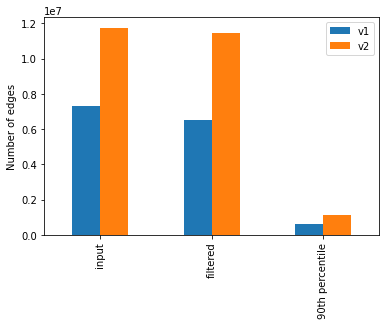

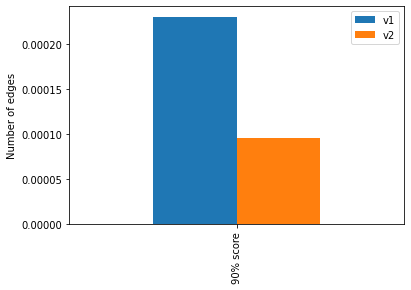

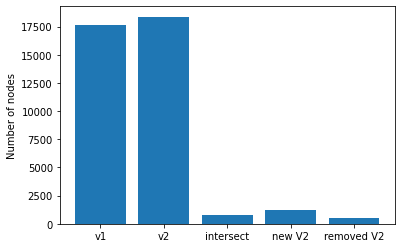

In [51]:
stats.loc[["input","filtered", "90th percentile"]].plot.bar(ylabel="Number of edges")
stats.loc[["90% score"]].plot.bar(ylabel="Number of edges")
plt.figure()
plt.bar(["v1", "v2", "intersect", "new V2", "removed V2"], [len(nodes_v1), len(nodes_v2), len(nodes_v2)-len(nodes_v1),
                                                           len(nodes_v2.difference(nodes_v1)), len(nodes_v1.difference(nodes_v2))])
plt.ylabel("Number of nodes")